<a href="https://colab.research.google.com/github/ThiruvarankanM/mnist-handwritten-digits-pytorch/blob/main/MNIST_Image_Classification_using_PyTorch_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Image Classification using PyTorch CNN

This notebook demonstrates building, training, and evaluating a Convolutional Neural Network (CNN) on the MNIST dataset using PyTorch.

We will go step by step:
1. Import dependencies
2. Load and explore the dataset
3. Build a CNN model
4. Train the model
5. Evaluate the model
6. Save and load the trained model
7. Make predictions on new images

# 1️⃣ Import Dependencies

In [1]:
import torch
from torch import nn, save, load
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt

# 2️⃣ Load and Explore the MNIST Dataset

In [2]:
# Download MNIST dataset (handwritten digits 0-9)
train_data = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.MNIST(root="data", train=False, download=True, transform=ToTensor())

# Wrap datasets in DataLoader for batching
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 495kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.69MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.67MB/s]


In [3]:
# Check shape of a sample
sample_img, sample_label = train_data[0]
print("Image shape:", sample_img.shape)
print("Label:", sample_label)

Image shape: torch.Size([1, 28, 28])
Label: 5


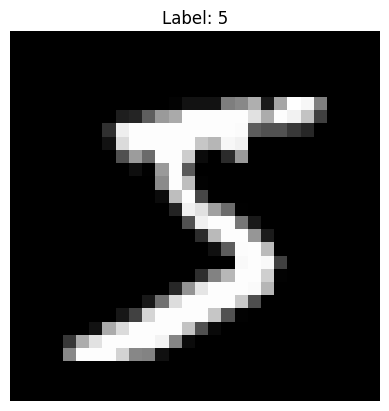

In [4]:
# Display a sample image
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.title(f"Label: {sample_label}")
plt.axis('off')
plt.show()

# 3️⃣ Build the Convolutional Neural Network

In [5]:

class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3), # input 1 channel, output 32 channels
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*(28-6)*(28-6), 10) # 10 classes (digits 0-9)
        )

    def forward(self, x):
        return self.model(x)

In [6]:
# Instantiate the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
clf = ImageClassifier().to(device)
print(clf)

ImageClassifier(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=30976, out_features=10, bias=True)
  )
)


# 4️⃣ Define Loss Function and Optimizer

In [7]:
loss_fn = nn.CrossEntropyLoss()   # suitable for classification
optimizer = Adam(clf.parameters(), lr=1e-3)

# 5️⃣ Training Loop

In [8]:
epochs = 10
for epoch in range(epochs):
    running_loss = 0
    for batch in train_loader:
        X, y = batch
        X, y = X.to(device), y.to(device)

        # Forward pass
        yhat = clf(X)
        loss = loss_fn(yhat, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/10 | Loss: 0.1200
Epoch 2/10 | Loss: 0.0411
Epoch 3/10 | Loss: 0.0267
Epoch 4/10 | Loss: 0.0181
Epoch 5/10 | Loss: 0.0127
Epoch 6/10 | Loss: 0.0100
Epoch 7/10 | Loss: 0.0082
Epoch 8/10 | Loss: 0.0064
Epoch 9/10 | Loss: 0.0058
Epoch 10/10 | Loss: 0.0029


# 6️⃣ Evaluate the Model on Test Data

In [9]:
clf.eval()  # set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        yhat = clf(X)
        preds = torch.argmax(yhat, dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy*100:.2f}%")


Test Accuracy: 98.83%


# 7️⃣ Save and Load the Model

In [10]:
# Save model weights
torch.save(clf.state_dict(), 'mnist_cnn_model.pt')

# Load model weights
clf_loaded = ImageClassifier().to(device)
clf_loaded.load_state_dict(torch.load('mnist_cnn_model.pt'))
clf_loaded.eval()


ImageClassifier(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=30976, out_features=10, bias=True)
  )
)

# 8️⃣ Predict on a New Image

In [13]:
# Load an image (grayscale, 28x28)
img = Image.open('sample_image.jpg').convert('L')  # convert to grayscale
img_tensor = ToTensor()(img).unsqueeze(0).to(device)  # add batch dimension

# Prediction
with torch.no_grad():
    pred = torch.argmax(clf_loaded(img_tensor))
print(f"Predicted label: {pred.item()}")


Predicted label: 9
